In [1]:
# loading all necessary libraries
import requests, csv, glob, pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

# Question 1

Here we define some useful parameters

In [2]:
# informatique (value for URL parameter)
unite_acad = '249847'
# all years from 2007 till 2016 (values in the URL parameter)
periode_acad = ['978181', '978187', '978195', '39486325', '123455150', '123456101', '213637754', '213637922', '213638028', '355925344']
# all bachelor semesters from 1st to 6th (values in the URL parameter)
periode_pedago = ['249108', '249114', '942155', '942163', '942120', '2226768', '942175', '2226785']
# filtered periode_pedago (we are only interested in semesters 1, 6, 6b)
periode_pedago_filtered = [periode_pedago[0],periode_pedago[-2],periode_pedago[-1]]
# all years from 2007 till 2016
years = list(range(2007,2017))
# semesters we are interested in
semesters = ['1','6','6b']

We define the function that will parse our html files

In [3]:
def my_parse(html):
    '''
    this function is used to parse the html files downloaded from isa.epfl.ch
    it extracts the context of the html table that contains all registered information about the students (this information is located between the <td> and <tr> attributes of the html page)
    
    Arguments
    html: contains the html page in string format
    '''
    table = []
    soup = BeautifulSoup(html, 'html.parser')
    # we keep the information between the table attribute
    content = soup.find_all('table')[0]
    # we keep the information between the <tr> and <td> attributes which is the context of each cell for each row
    for tr in content.find_all('tr'):
        tds = tr.find_all('td')
        table.append([elem.text.rstrip('\n').replace(u'\xa0', u' ') for elem in tr])
    # we return the whole html table as a list of lists
    return table

Here is a function that creates a csv file which will be later used to load dataframes

** We save the data to csv files in order to avoid making the http requests every time we run the code**

In [4]:
def tableToCSV(table, file_name):
    '''
    this function is used to print the content of the html table in a csv file

    Arguments
    table:      is a list of list. each sublist contains the payload of a row
                of the html table
    file_name:  specifies the file name
    '''
    started = False
    # we skip some rows that do not contain useful information
    for row in table:
        if row[0].startswith('Civil'):
            started = True
            f = open(file_name, 'w')
        if started:
            f.write('|'.join(row)+'\n')
    if started:
        f.close()

We put all the URL parameters in a dictionary, since the requests.get() function works in that way

In [5]:
payload = {'ww_x_GPS':'-1', 
           'ww_i_reportModel':'133685247', 
           'ww_i_reportModelXsl':'133685270', 
           'ww_x_UNITE_ACAD':unite_acad, 
           # we keep the last two parameters with no values, since we will define this value later
           'ww_x_PERIODE_ACAD':'', 
           'ww_x_PERIODE_PEDAGO':''}

In [6]:
# base url
url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'

We iterate through all years from 2007 to 2016 (using the values of the url parameters) and fetch information about semester 1, 6 and 6b for each year

In [7]:
for i in range(0, len(periode_acad)):
    # we iterate through all the semesters we are interested in, namely 1, 6, and 6b (using the respective values for the URL parameter)
    for j in range(0, len(periode_pedago_filtered)):
        payload['ww_x_PERIODE_ACAD'] = periode_acad[i]
        payload['ww_x_PERIODE_PEDAGO'] = periode_pedago_filtered[j]
        # send request to fetch the page
        page = requests.get(url, params = payload)
        # keep only the text of the response, namely the html file and parse it
        rows = my_parse(page.text)
        # specify file name according to year and semester
        file_name = 'Data/bachelor/bachelor_' + str(years[i]) + '_sem_' + semesters[j]
        # save data to csv file (if file is emtpy, then skip) in order to avoid making the request every
        # time we run the code
        if rows:
            tableToCSV(rows, file_name)

We fetched all the data we need and we can start loading the csv files into dataframes

## Data loading

We start by loading all Bachelor students registered in Semester 1 from 2007 till 2016

In [8]:
# define path
all_semester_1 = glob.glob('Data/bachelor' + '/*sem_1')
# initialize dataframe for all sem 1 students from 2007 till 2016
semester_1_students = pd.DataFrame()
list_semester_1 = []
for file_name in all_semester_1:
    df = pd.read_csv(file_name, sep='|', index_col = False)
    # append year column to indicate when was each student registered
    df['year_1'] = int(file_name.split('_')[1])
    list_semester_1.append(df)
# concatenate dataframes
semester_1_students = pd.concat(list_semester_1)
semester_1_students.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,year_1
0,Monsieur,Albrecht Pablo,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,212726,2012
1,Monsieur,Alvard Edouard,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,223371,2012
2,Madame,Ammann Gaëlle,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,228116,2012
3,Monsieur,Amorim Afonso Caldeira Da Silva Pedro Maria,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,213618,2012
4,Monsieur,Amrani Kamil,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,226305,2012


In [9]:
semester_1_students[semester_1_students.year_1 == 2016].tail()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,year_1
230,Monsieur,Zeller Corentin Luc Claude,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,276323,2016
231,Monsieur,Zerbib Jeremy Moïsche Tsion,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,257715,2016
232,Monsieur,Zghonda Jalel,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,257393,2016
233,Monsieur,Zhou Jianhan,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,250422,2016
234,Monsieur,Zumbach Yves Arnaud,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,269845,2016


In [10]:
semester_1_students.shape

(1719, 12)

We load all Bachelor students registered in Semester and 6b from 2007 till 2016

(Assumption: we assume that stundents registered in semester 6 and 6b are registered in the 6th semester since the difference between 6 and 6b is not clear)

In [11]:
# define path
all_semester_6 = glob.glob('Data/bachelor' + '/*sem_6*')
# initialize dataframe for all sem 1 students from 2007 till 2016
semester_6_students = pd.DataFrame()
list_semester_6 = []

for file_name in all_semester_6:
    df = pd.read_csv(file_name, sep = '|', index_col = False)
    # append year column to indicate when was each student registered
    df['year_6'] = int(file_name.split('_')[1])
    list_semester_6.append(df)
# concatenate dataframes - put all bachelor students of semester 6 in the same dataframe
semester_6_students = pd.concat(list_semester_6)
semester_6_students = semester_6_students[['No Sciper', 'year_6']]
semester_6_students.head()

,No Sciper,year_6
0,174774,2008
1,170220,2008
2,166701,2008
3,170654,2008
4,161279,2008


In [12]:
semester_6_students.shape

(664, 2)

We join the dataframes that contain bachelor students from semester 1 and semester 6 (sciper is used as join key)

In [13]:
merged = pd.merge(semester_1_students, semester_6_students, how = 'inner', on = 'No Sciper')
merged = merged[['Civilité', 'Nom Prénom', 'No Sciper', 'year_1', 'year_6']]
merged.tail(10)

,Civilité,Nom Prénom,No Sciper,year_1,year_6
605,Monsieur,Rutz Valentin Bernard Roger Alain,203909,2011,2013
606,Madame,Salathé Joanna Béatrice,217489,2011,2013
607,Monsieur,Séchaud Gaétan,217500,2011,2013
608,Monsieur,Séguy Louis Marie James,204222,2011,2014
609,Monsieur,Sidorenko Semion,208359,2011,2014
610,Monsieur,Sikiaridis Alexandre Jean Denis,217469,2011,2013
611,Madame,Verstegen Noortje,214015,2011,2013
612,Monsieur,Walch Pierre,217124,2011,2013
613,Monsieur,Zellweger Fabien André,209450,2011,2014
614,Monsieur,Zellweger Fabien André,209450,2011,2013


Here we notice that some students (e.g. Wirz Leonardo Enrique with sciper 227775) have duplicate records. We want to keep the last record, so we sort according to year and drop duplicates by keeping the last valid record

In [14]:
# sort according to year_6
merged.sort_values(by = 'year_6', ascending = True, inplace = True)
# drop duplicates (if a sciper number appears more than once)
merged.drop_duplicates(subset = 'No Sciper', keep = 'last', inplace = True)
merged.head()

,Civilité,Nom Prénom,No Sciper,year_1,year_6
226,Monsieur,Schädeli Andreas,178948,2007,2009
225,Monsieur,Richter Arnaud,171195,2007,2009
224,Monsieur,Restani Stéphane,180959,2007,2009
177,Monsieur,Arévalo Christian,169569,2007,2009
203,Monsieur,Habfast Paul,180570,2007,2009


A student that started in 2007-2008 finished in 2009-2010 (this is why we add + 1 to year_6). Moreover, we assume that each semester is 6 months and that each year has two semesters

In [15]:
merged['months'] = ((merged.year_6 + 1) - merged.year_1) * 12
merged.head()

,Civilité,Nom Prénom,No Sciper,year_1,year_6,months
226,Monsieur,Schädeli Andreas,178948,2007,2009,36
225,Monsieur,Richter Arnaud,171195,2007,2009,36
224,Monsieur,Restani Stéphane,180959,2007,2009,36
177,Monsieur,Arévalo Christian,169569,2007,2009,36
203,Monsieur,Habfast Paul,180570,2007,2009,36


We calculate the number of men and women that have registered for both semester 1 and 6

In [16]:
merged.groupby(by = 'Civilité').count().months

Civilité
Madame       29
Monsieur    368
Name: months, dtype: int64

Now we calculate the average number of months needed for men and women to finish ther bachelor studies

In [17]:
merged.groupby(by = 'Civilité').mean().months

Civilité
Madame      39.310345
Monsieur    40.467391
Name: months, dtype: float64

We see that the average study duration for men and women are pretty close

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76e42ab5f8>]], dtype=object)

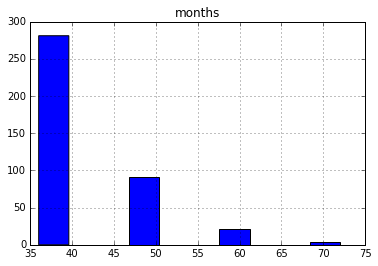

In [18]:
merged.hist(column='months')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76e4258278>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f76e40ec6d8>], dtype=object)

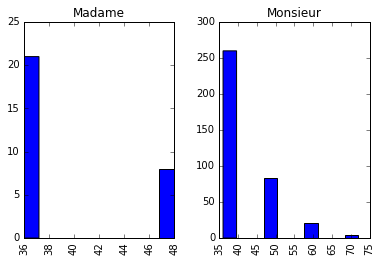

In [19]:
merged.hist(column='months', by='Civilité')

**Now we will check if the difference in the study duration of men and women is statistically significant**

We want to test whether the average study duration of men differs from the women. The null hypothesis would be that there is no difference between the average study duration.

The purpose of a hypothesis test is to determine whether the null hypothesis is likely to be true given sample data. We use the **two-sample t-test** which investigates whether the means of two independent data samples differ from one another. The right statistical test was chosen using the theory from [Hypothesis Testing and the T-Test][1]

For typical analysis, using the standard α = 0.05 cutoff, we have strong evidence against the null hypothesis if p < 0.05.

We calculate the p-value to see if we have strong evidence against the null hypothesis

[1]:http://hamelg.blogspot.ch/2015/11/python-for-data-analysis-part-24.html

In [20]:
men = merged[merged['Civilité'] == 'Monsieur']
men.shape

(368, 6)

In [21]:
men.describe()['months']

count    368.000000
mean      40.467391
std        7.722646
min       36.000000
25%       36.000000
50%       36.000000
75%       48.000000
max       72.000000
Name: months, dtype: float64

In [22]:
women = merged[merged['Civilité'] == 'Madame']
women.shape

(29, 6)

In [23]:
women.describe()['months']

count    29.000000
mean     39.310345
std       5.458306
min      36.000000
25%      36.000000
50%      36.000000
75%      48.000000
max      48.000000
Name: months, dtype: float64

In [24]:
r = stats.ttest_ind(a=men['months'], b=women['months'], equal_var=False)
print('p-value = ', np.round(r[1], 4))

p-value =  0.2955


The p-value is greater than 0.05, which indicates that there is strong evidence in favor of the null hypothesis. Therefore, the difference in the average study duration between men and women is most likely not to be statistically significant

# Question 2

We redefine the variables for the Master students

In [25]:
# informatique (value for URL parameter)
unite_acad = '249847'
# all years from 2007 till 2016 (values in the URL parameter)
periode_acad = ['978181', '978187', '978195', '39486325', '123455150', '123456101', '213637754', '213637922', '213638028', '355925344']
# all master semesters from 1st to 3rd (values in the URL parameter)
periode_pedago = ['2230106', '942192', '2230128']
# filtered periode_pedago (we are only interested in semesters 1, 6, 6b)
# all years from 2007 till 2016
years = list(range(2007,2017))
# semesters we are interested in
semesters = ['1','2','3']

We fetch all student records from 2007 to 2016 for semesters 1 through 3 (there are no records for the 4th semester)

In [26]:
for i in range(0, len(periode_acad)):
    # we iterate through all the semesters we are interested in, namely 1, 2, and 3 (using the respective values for the URL parameter)
    for j in range(0, len(periode_pedago)):
        payload['ww_x_PERIODE_ACAD'] = periode_acad[i]
        payload['ww_x_PERIODE_PEDAGO'] = periode_pedago[j]
        # send request to fetch the page
        page = requests.get(url, params = payload)
        # keep only the text of the response, namely the html file and parse it
        rows = my_parse(page.text)
        # specify file name according to year and semester
        file_name = 'Data/master/master_' + str(years[i]) + '_sem_' + semesters[j]
        # save data to csv file (if file is empty then skip)
        if rows:
            tableToCSV(rows, file_name)

Define function that returns all master students according to semester

In [27]:
def getMasterStudents(semester, path):
    '''
    returns a dataframe with all master students registered in a specific semester for all years
    
    Arguments
    semester: number of semester
    path:     path to files (name of directory)
    '''
    # define path
    regex = '/*sem_' + str(semester)
    all_master = glob.glob('Data/' + path + regex)
    # initialize dataframe for all sem 1 students from 2007 till 2016
    master_students = pd.DataFrame()
    list_master = []
    for file_name in all_master:
        df = pd.read_csv(file_name, sep='|', index_col = False)
        # append year column to indicate when was each student registered
        col = 'year_'+str(semester)
        df[col] = int(file_name.split('_')[1])
        list_master.append(df)
    # concatenate dataframes
    master_students = pd.concat(list_master)
    return master_students

Get master students for each year for all semesters (1,2 and 3) and put them into a single dataframe

In [28]:
all_master_students = pd.DataFrame()
list_students = []
# iterate through all semesters
for semester in range(1,4):
    students = getMasterStudents(semester, 'master')
    list_students.append(students)
# concatenate all master students in one dataframe
all_master_students = pd.concat(list_students)
# create column that indicates if someone follows the 120 ECTS program (has a minor/specialization)
# initialize values to 'no'
all_master_students['120ECTS'] = 'no'
all_master_students.head()

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,year_1,year_2,year_3,120ECTS
0,Monsieur,NaN,NaN,NaN,166075,Amiguet Jérôme,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,no
1,Monsieur,NaN,NaN,NaN,245182,Anadon Laurent Marie Patrick,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,no
2,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,no
3,Monsieur,NaN,NaN,NaN,244650,Ashton Jean Scott Elie Marie,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,no
4,Monsieur,NaN,NaN,NaN,245311,Basil John Sachin,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,no


We seperate all students who have a specialization or Minor (120 ECTS) from those who have not (90 ECTS). We wish to have an average study duration for students who follow the 90 ECTS program and for those who chose the 120 ECTS program seperately

In [29]:
# index of students who have minor
index_mineur_yes = all_master_students['Mineur'].notnull()
# index of students who have specialization
index_specialization_yes = all_master_students['Spécialisation'].notnull()

# keep sciper number of students with minor
sciper_minor = all_master_students.loc[index_mineur_yes, 'No Sciper']
sciper_minor = sciper_minor.to_frame()
sciper_minor.drop_duplicates(subset = 'No Sciper', inplace = True)
sciper_minor = sciper_minor['No Sciper'].values.tolist()

# keep sciper number of students with specialization
sciper_specialization = all_master_students.loc[index_specialization_yes, 'No Sciper']
sciper_specialization = sciper_specialization.to_frame()
sciper_specialization.drop_duplicates(subset = 'No Sciper', inplace = True)
sciper_specialization = sciper_specialization['No Sciper'].values.tolist()

# set '120ECTS' variable to 'yes' for those who have a minor/specialization
all_master_students.set_value(all_master_students['No Sciper'].isin(sciper_minor), '120ECTS', 'yes')
all_master_students.set_value(all_master_students['No Sciper'].isin(sciper_specialization), '120ECTS', 'yes')

all_master_students.head()

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,year_1,year_2,year_3,120ECTS
0,Monsieur,NaN,NaN,NaN,166075,Amiguet Jérôme,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,no
1,Monsieur,NaN,NaN,NaN,245182,Anadon Laurent Marie Patrick,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,no
2,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,yes
3,Monsieur,NaN,NaN,NaN,244650,Ashton Jean Scott Elie Marie,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,no
4,Monsieur,NaN,NaN,NaN,245311,Basil John Sachin,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,yes


We set variables to fetch students from the "Project Master" tables of ISA

In [30]:
# informatique (value for URL parameter)
unite_acad = '249847'
# all years from 2007 till 2016 (values in the URL parameter)
periode_acad = ['978181', '978187', '978195', '39486325', '123455150', '123456101', '213637754', '213637922', '213638028', '355925344']
# all master semesters from 1st to 3rd (values in the URL parameter)
periode_pedago = ['249127', '3781783']
# filtered periode_pedago (we are only interested in semesters 1, 6, 6b)
# all years from 2007 till 2016
years = list(range(2007,2017))
semesters = ['autumn','spring']

We fetch all the students that did or are currently doing their master thesis from the Progect Master option of the ISA

In [31]:
for i in range(0, len(periode_acad)):
    # we iterate through all the semesters we are interested in, namely autumn and spring semester (using the respective values for the URL parameter)
    for j in range(0, len(periode_pedago)):
        payload['ww_x_PERIODE_ACAD'] = periode_acad[i]
        payload['ww_x_PERIODE_PEDAGO'] = periode_pedago[j]
        # send request to fetch the page
        page = requests.get(url, params = payload)
        # keep only the text of the response, namely the html file and parse it
        rows = my_parse(page.text)
        # specify file name according to year and semester
        file_name = 'Data/thesis/thesis_' + str(years[i]) + '_sem_' + semesters[j]
        # save data to csv file (if file is empty then skip)
        if rows:
            tableToCSV(rows, file_name)

We found the same sciper in more than one records for students who did their project thesis, therefore we drop duplicates

In [32]:
thesis_students = pd.DataFrame()
list_students = []
for semester in semesters:
    students = getMasterStudents(semester, 'thesis')
    list_students.append(students)
thesis_students = pd.concat(list_students)
thesis_students = thesis_students['No Sciper']
thesis_students = thesis_students.to_frame()
thesis_students.drop_duplicates(subset='No Sciper', inplace=True)
thesis_students.head()

,No Sciper
0,196669
1,200065
2,171619
3,200597
4,170239


In [33]:
thesis_students.shape

(121, 1)

Graduates are students that did their complete master studies at EPFL (courses + thesis). Therefore, we join master students and students registered in the "Project Master" in order to end up with graduates

In [34]:
graduated = pd.merge(all_master_students, thesis_students, how='inner')

We test if all the students registeredin the project list are also registered during the semester

In [35]:
# sciper number of students who graduated
scip_num = graduated['No Sciper'].tolist()
# sciper number of those who did their thesis and are also in the scip_num dataframe
sciper_grad = thesis_students['No Sciper'].isin(scip_num)
sciper_not_grad = ~sciper_grad
# sciper number of student who did hir/her thesis but was not registered in the Master students
thesis_students[sciper_not_grad].drop_duplicates()

,No Sciper
0,173527


We found that there is such a student

In [36]:
# graduated['120ECTS'] = np.where((graduated['Mineur'].notnull() | graduated['Spécialisation'].notnull()), 'yes', 'no')
# graduated[['No Sciper', 'Nom Prénom', 'Spécialisation', 'Mineur', '120ECTS']].head()

We group students who graduated by specialization/minor and sciper number to calculate the average study duration

In [37]:
grouped = graduated.groupby(by = ['120ECTS', 'Civilité', 'No Sciper']).count().reset_index()
grouped.set_index(['120ECTS', 'No Sciper'], inplace=True)
grouped = grouped[['Civilité', 'Nom Prénom']]
grouped.columns = ['Civilité', 'Count']
grouped.shape

(120, 2)

The **grouped** dataframe contains all students that have graduated. Therefore, we should increase the 'count' column by one for the thesis semester

In [38]:
grouped['Count'] = grouped['Count'] + 1
grouped.head()

Civilité  Count
120ECTS No Sciper                
no      180027      Madame      3
        183512      Madame      3
        183605      Madame      3
        200065      Madame      3
        225388      Madame      3

We drop students that have a count <= 2 (2 semesters) because it is not possible to graduate after two semesters. We cannot treat the data otherwise because of missing data of the ISA

In [39]:
grouped = grouped[grouped['Count'] > 2]
grouped.head()

Civilité  Count
120ECTS No Sciper                
no      180027      Madame      3
        183512      Madame      3
        183605      Madame      3
        200065      Madame      3
        225388      Madame      3

In [40]:
grouped.shape

(115, 2)

We calculate the average study duration of men and women who have or have not a specialization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76e4043630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f76e41bb2e8>]], dtype=object)

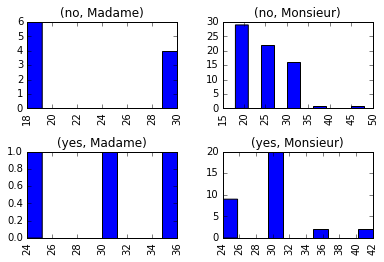

In [41]:
grouped.reset_index(inplace = True)
grouped['Count'] = grouped['Count'] * 6
grouped.hist(column='Count', by=['120ECTS', 'Civilité'])

We want to test if the difference in the study duration of men and women without specialization is statistically significant. Therefore, we perform the following analysis

In [42]:
men_without_specialization = grouped[(grouped['120ECTS'] == 'no') & (grouped['Civilité'] == 'Monsieur')]
women_without_specialization = grouped[(grouped['120ECTS'] == 'no') & (grouped['Civilité'] == 'Madame')]

In [43]:
r = stats.ttest_ind(a=men_without_specialization['Count'], b=women_without_specialization['Count'], equal_var=False)
print('p-value = ', np.round(r[1], 4))

p-value =  0.7814


Since the p-value is greater than 0.05, we have strong evidence in favor of the null hypothesis. Therefore, the difference in the average study of men and women without specialization is **not** considered to be statistically significant

We want to test if the difference in the study duration of men and women with specialization is statistically significant. Therefore, we perform the following analysis

In [44]:
men_with_specialization = grouped[(grouped['120ECTS'] == 'yes') & (grouped['Civilité'] == 'Monsieur')]
women_with_specialization = grouped[(grouped['120ECTS'] == 'yes') & (grouped['Civilité'] == 'Madame')]

In [45]:
r = stats.ttest_ind(a=men_with_specialization['Count'], b=women_with_specialization['Count'], equal_var=False)
print('p-value = ', np.round(r[1], 4))

p-value =  0.8909


Since the p-value is greater than 0.05, we have strong evidence in favor of the null hypothesis. Therefore, the difference in the average study of men and women without specialization is **not** considered to be statistically significant

Here, we present the average study duration for men and women with and without specialization

In [46]:
grouped = grouped.groupby(by = ['120ECTS', 'Civilité'], as_index = True).mean()
grouped.drop('No Sciper', axis = 1, inplace=True)
grouped['Count'].head()

120ECTS  Civilité
no       Madame      22.800000
         Monsieur    23.391304
yes      Madame      30.000000
         Monsieur    29.454545
Name: Count, dtype: float64

Since the number of registered graduates in ISA is very small, we forget about the "Project Master" tables of the ISA and start making our own assumptions

We find all student that have been registered for at least 2 semester. We find those who have chosen a specialization/minor and those who have not. For the first category, we assume a minimum study duration of 24 months and for the latter we assume a minimum study duration of 18 months. 

We get rid of active students (apart from students that are currently doing their thesis) who are not yet able to start their thesis in the next semester

In order to make that more clear we give some examples:
* a student who is registered in only one semester is considered as a new master student and is not included in our analysis
* a student with a specialization/minor and a sum of 2 semesters needs at least 2 more semesters to finish the studies, so he/she is not included in our analysis
* a student with no specialization/minor and a sum of 2 semesters is considered to finish in the next semester
* a student with specialization/minor and a sum of 3 semesters is considered to finish in the next semester

In order to do the aforementioned analysis, all students that did or are currently doing their thesis are removed from the **all_master_students** dataframe

In [47]:
all_master_students.shape

(2716, 15)

In [48]:
# here we remove all students that graduated / are currently doing their thesis 
students = all_master_students[~all_master_students['No Sciper'].isin(scip_num)]
students.shape

(2342, 15)

We count the study duration of each student and keep information about his/her sex and the program he/she chose (120 ECTS: 'yes' or 'no')

In [49]:
grouped = graduated.groupby(by = ['120ECTS', 'Civilité', 'No Sciper']).count().reset_index()
grouped.set_index('No Sciper', inplace=True)
grouped = grouped[['120ECTS','Civilité', 'Nom Prénom']]
grouped.rename(columns={'Nom Prénom': 'Count'}, inplace=True)
grouped.head()

,120ECTS,Civilité,Count
No Sciper,,,
180027,no,Madame,2
183512,no,Madame,2
183605,no,Madame,2
200065,no,Madame,2
225388,no,Madame,2


We remove students who are still studying. This means:
* students that have no minor/specialization and are only registered in one semester
* students that have a minor/specialization and are registered in only two semester

In [50]:
grouped = grouped[((grouped['120ECTS'] == 'no') & (grouped['Count'] > 1) | 
                 (grouped['120ECTS'] == 'yes') & (grouped['Count'] > 2))]
grouped.head()

,120ECTS,Civilité,Count
No Sciper,,,
180027,no,Madame,2
183512,no,Madame,2
183605,no,Madame,2
200065,no,Madame,2
225388,no,Madame,2


We make the following assumptions for our analysis:

* students who have no minor/specialization and are already for 2 semesters at EPFL are going to graduate in the next semester
* students who have a minor/specialization and are already for 3 semesters at EPFL are going to graduate in the next semester

We add one more semester to the study duration of all student that satisfy the aforementioned criteria

Moreover, we assume that:

* students who have not chosen any minor/specialization and are already registered for 3 semesters are considered as graduates
* students who have chosen a minor/specialization and are already registered for 4 semesters are also considered as graduates

Finally, we assume that:
* students who do their internship at a company also did their master thesis there
* students who did their thesis at EPFL, did a summer internship

The two last assumptions mean that the expected study duration is 3 and 4 semesters for students without and with specialization respectively

In [51]:
grouped.set_value((grouped['120ECTS'] == 'no') & (grouped['Count'] == 2), 'Count', 3)
grouped.head()

,120ECTS,Civilité,Count
No Sciper,,,
180027,no,Madame,3
183512,no,Madame,3
183605,no,Madame,3
200065,no,Madame,3
225388,no,Madame,3


In [52]:
grouped.set_value((grouped['120ECTS'] == 'yes') & (grouped['Count'] == 3), 'Count', 4)
grouped.tail()

,120ECTS,Civilité,Count
No Sciper,,,
218353,yes,Monsieur,4
227848,yes,Monsieur,4
233543,yes,Monsieur,4
244136,yes,Monsieur,4
244587,yes,Monsieur,4


We convert 'Count' from semesters to months

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76e175f550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f76e443afd0>], dtype=object)

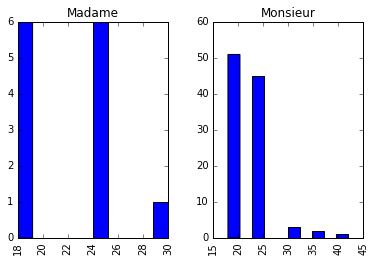

In [53]:
grouped['Count'] = grouped['Count'] * 6
grouped.hist(column='Count', by='Civilité')

We test if the difference in the study duration between men and women without specialization is statistically significant. Therefore, we follow the methodology presented in the first part of the exercise

In [54]:
men_without_specialization = grouped[(grouped['120ECTS'] == 'no') & (grouped['Civilité'] == 'Monsieur')]
women_without_specialization = grouped[(grouped['120ECTS'] == 'no') & (grouped['Civilité'] == 'Madame')]

In [55]:
r = stats.ttest_ind(a=men_without_specialization['Count'], b=women_without_specialization['Count'], equal_var=False)
print('p-value = ', np.round(r[1], 4))

p-value =  0.6614


Since the p-value is greater than 0.05, we have strong evidence in favor of the null hypothesis. Therefore, the difference in the average study of men and women without specialization is **not** considered to be statistically significant

We repeat the same process for men and women with specialization

In [56]:
men_with_specialization = grouped[(grouped['120ECTS'] == 'yes') & (grouped['Civilité'] == 'Monsieur')]
women_with_specialization = grouped[(grouped['120ECTS'] == 'yes') & (grouped['Civilité'] == 'Madame')]

In [57]:
r = stats.ttest_ind(a=men_with_specialization['Count'], b=women_with_specialization['Count'])
print('p-value = ', np.round(r[1], 4))

p-value =  0.6389


The p-value is again greater than 0.05. Therefore, we have strong evidence in favor of the null hypothesis and believe that the difference in the average study of men and women with specialization is **not** considered to be statistically significant

We calculate the average study duration of men and women who have or have not a specialization

In [58]:
grouped.reset_index(inplace = True)
grouped = grouped.groupby(by = ['120ECTS', 'Civilité'], as_index = True).mean()
grouped.drop('No Sciper', axis = 1, inplace=True)
grouped

Count
120ECTS Civilité           
no      Madame    20.400000
        Monsieur  19.913043
yes     Madame    26.000000
        Monsieur  25.090909

However, we know that this result is biased as we made the assumption of adding one semester to students who are about to finish their studies in the next semester. Moreover, we made the assumption that the expected study duration is 3 / 4 semesters for students without / with specialization respectively. However, this is not always the case since some students choose to take less than 30 ECTS per semester, may fail in a course, work, etc. All these reasons extend the study duration beyond the minimum expected. However, we are not able to capture such events from the ISA records. Therefore, we stick to the assumption described before but clarify that our results are biased.

Now, we extract all the students with a Spécialisation and compute the average stay per each category of that attribute

In [59]:
students_specialization = all_master_students[all_master_students['No Sciper'].isin(sciper_specialization)]
students_specialization.head(2)

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,year_1,year_2,year_3,120ECTS
2,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,yes
4,Monsieur,NaN,NaN,NaN,245311,Basil John Sachin,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,yes


We discover the following problem: some students with specialization appear to have NaN values in the respective field for early semesters

In [60]:
students_specialization[students_specialization['No Sciper'] == 194182]

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,year_1,year_2,year_3,120ECTS
2,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,NaN,Présent,NaN,2014.0,NaN,NaN,yes
4,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,NaN,Congé,NaN,2013.0,NaN,NaN,yes
2,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,Foundations of Software,Présent,NaN,NaN,2014.0,NaN,yes
7,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,Foundations of Software,Présent,NaN,NaN,2015.0,NaN,yes
4,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,NaN,Congé,NaN,NaN,2013.0,NaN,yes
0,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,Foundations of Software,Présent,NaN,NaN,NaN,2015.0,yes


In order to perfom the groupby() operation per specialization, we have to get rid of these NaN values by replacing them with the actual specialization title

In [61]:
grouped_by_sciper = students_specialization.groupby('No Sciper')
titles = grouped_by_sciper['Spécialisation'].transform('first')

In [62]:
# check if the titles we created contain any NaN
titles.isnull().values.any()

False

In [63]:
titles.head()

2            Foundations of Software
4                   Software Systems
5                 Internet computing
6     Signals, Images and Interfaces
10                Internet computing
dtype: object

In [64]:
# set specialization to titles
students_specialization['Spécialisation'] = titles
students_specialization.head()

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,year_1,year_2,year_3,120ECTS
2,Monsieur,NaN,NaN,NaN,194182,Antognini Marco,NaN,NaN,Foundations of Software,Présent,NaN,2014.0,NaN,NaN,yes
4,Monsieur,NaN,NaN,NaN,245311,Basil John Sachin,NaN,NaN,Software Systems,Présent,NaN,2014.0,NaN,NaN,yes
5,Monsieur,NaN,NaN,NaN,185991,Benhamadi Yassine,NaN,NaN,Internet computing,Présent,NaN,2014.0,NaN,NaN,yes
6,Monsieur,NaN,NaN,NaN,204393,Berdat Johan,NaN,NaN,"Signals, Images and Interfaces",Présent,NaN,2014.0,NaN,NaN,yes
10,Monsieur,NaN,NaN,NaN,214637,Bovet Sidney,NaN,NaN,Internet computing,Présent,NaN,2014.0,NaN,NaN,yes


In [65]:
students_specialization[students_specialization['No Sciper'] == 185991]

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,year_1,year_2,year_3,120ECTS
5,Monsieur,NaN,NaN,NaN,185991,Benhamadi Yassine,NaN,NaN,Internet computing,Présent,NaN,2014.0,NaN,NaN,yes
11,Monsieur,NaN,NaN,NaN,185991,Benhamadi Yassine,NaN,NaN,Internet computing,Présent,NaN,NaN,2014.0,NaN,yes
11,Monsieur,NaN,NaN,NaN,185991,Benhamadi Yassine,NaN,NaN,Internet computing,Présent,NaN,NaN,2015.0,NaN,yes
8,Monsieur,NaN,NaN,NaN,185991,Benhamadi Yassine,NaN,NaN,Internet computing,Présent,NaN,NaN,NaN,2016.0,yes
4,Monsieur,NaN,NaN,NaN,185991,Benhamadi Yassine,NaN,NaN,Internet computing,Présent,NaN,NaN,NaN,2015.0,yes


We group by specialization and sciper number to find the study duration of each student

In [66]:
# group by specialization and sciper number
grouped = students_specialization.groupby(by=['Spécialisation', 'No Sciper']).count()
grouped = grouped[['120ECTS']]
grouped.columns = ['Count']
grouped.head()

Count
Spécialisation No Sciper       
Biocomputing   153640         1
               154573         5
               154936         1
               154969         1
               160150         1

We keep only students with a study duration of more than 3 semesters

In [67]:
grouped = grouped[grouped['Count'] > 2]

We assume that students with a study duration of 3 semesters are going to graduate in the next semester, therefore we set 3 to 4

In [68]:
grouped.loc[grouped['Count'] == 3, 'Count'] = 4

We group by specialization and compute the average study duration for each specialization in months

In [69]:
grouped.reset_index(inplace=True)
grouped.drop('No Sciper', axis=1, inplace=True)
grouped.columns = ['Spécialisation', 'Count']
grouped.groupby(by='Spécialisation').mean() * 6

,Count
Spécialisation,
Biocomputing,27.000000
Computer Engineering - SP,24.900000
Computer Science Theory,24.000000
Data Analytics,24.000000
Foundations of Software,25.800000
Information Security - SP,24.000000
Internet Information Systems,24.000000
Internet computing,25.695652
Service science,24.000000


Here, we calculate the average study duration off all those that have chosen a specialization

In [70]:
specialization_mean = grouped['Count'].mean() * 6
specialization_mean

25.6

In [71]:
specializations = titles.unique()

We find how many students are registered per specialization

In [72]:
grouped.groupby('Spécialisation').count()

,Count
Spécialisation,
Biocomputing,4
Computer Engineering - SP,20
Computer Science Theory,1
Data Analytics,4
Foundations of Software,60
Information Security - SP,7
Internet Information Systems,1
Internet computing,92
Service science,4


We remove those specializations that have less than 10 records to get accurate results. Specializations with few records are new

Here, we will use the **one-sample t-test** to check whether the mean of a specific specialization differs from the mean of all specializations

In [73]:
for spec in specializations:
    df = grouped[grouped['Spécialisation'] == spec]
    if df.shape[0] > 10:
        r = stats.ttest_1samp(a=df['Count'] * 6, popmean=specialization_mean)
        print(spec, ': p-value = ', np.round(r[1], 4))

Foundations of Software : p-value =  0.6473
Software Systems : p-value =  0.0
Internet computing : p-value =  0.7991
Signals, Images and Interfaces : p-value =  0.1107
Computer Engineering - SP : p-value =  0.1706


Here, the null hypothtesis is that the average duration of each specialization is close to the general average of study duration with specialization. We have strong evidence against the null hypothesis for those specializations that have a p values smaller than 0.05 

## Data Visualization

We use scatterplots to visually identify changes over time. We focus on the Bachelor students

The Bachelor students who were registered in both Semester 1 and 6 are in the **merged** dataframe

In [74]:
merged.head()

,Civilité,Nom Prénom,No Sciper,year_1,year_6,months
226,Monsieur,Schädeli Andreas,178948,2007,2009,36
225,Monsieur,Richter Arnaud,171195,2007,2009,36
224,Monsieur,Restani Stéphane,180959,2007,2009,36
177,Monsieur,Arévalo Christian,169569,2007,2009,36
203,Monsieur,Habfast Paul,180570,2007,2009,36


In [75]:
groups = merged.groupby(by=['Civilité','year_1', 'months']).count()
groups.reset_index(inplace=True)
groups.rename(columns={'year_6': 'count'}, inplace=True)
groups = groups[['Civilité','year_1','months', 'count']]
groups.head()

,Civilité,year_1,months,count
0,Madame,2007,36,2
1,Madame,2008,36,4
2,Madame,2008,48,1
3,Madame,2009,36,1
4,Madame,2009,48,1


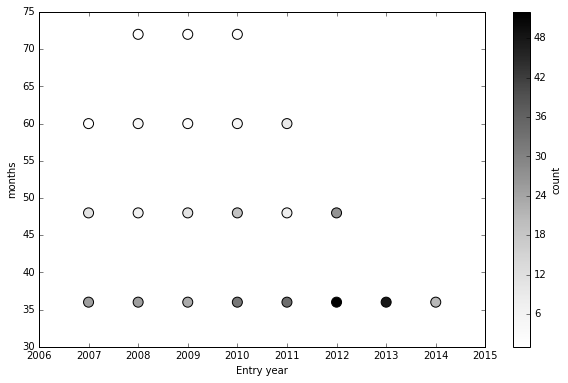

In [76]:
men = groups[groups['Civilité'] == 'Monsieur']
fig, ax = plt.subplots()
f = men.plot(kind='scatter', x='year_1', y='months', c='count', s=100, figsize=(10, 6), ax=ax);
lables = f.get_xticks()
years = pd.Series([int(item) for item in lables])
ax.set_xticklabels(years)
ax.set_xlabel('Entry year')

This figure shows the study duration for the bachelor male students registered both in Semester 1 and 6. The color intensity indicates the number of students. For example, the penultimate bullet in the first row indicates that more than 48 students manage to finish their  bachelor studies in 36 months in 2013

The figure shows that starting from 2010, the number of male students that need more than 36 months to finish their studies decreases

We see that starting from 2013, all students finish their bachelor studies after 36 months

Now, we perform the same analysis for female students

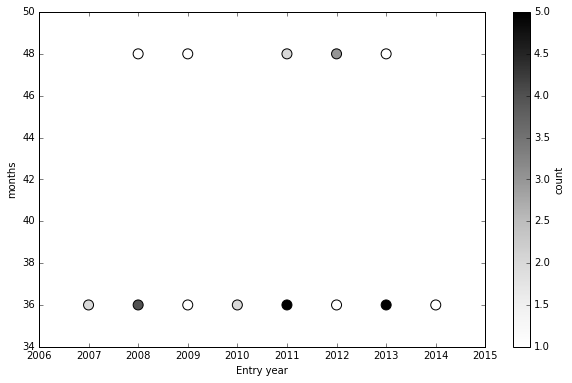

In [77]:
women = groups[groups['Civilité'] == 'Madame']
fig, ax = plt.subplots()
f = women.plot(kind='scatter', x='year_1', y='months', c='count', s=100, figsize=(10, 6), ax=ax);
labels = f.get_xticks()
years = pd.Series([int(item) for item in labels])
ax.set_xticklabels(years)
ax.set_xlabel('Entry year')

This figure shows the study duration for the bachelor female students registered both in Semester 1 and 6

The first thing that is noticable is that female students need either 36 or 48 months to finish their studies

2012 is the only year in which the majority of the female students needed 48 months to finish their studies

In all the other year, the majority of the female students finished after 36 months (there appears to be a tie in 2009)

Finally, we see that there in no trend to indicate that all female students tend to finish their studies in 36 months. We see that in each year, there exist female students to finish in 36 and 48 months